# **PREDICCIÓN DE VENTAS**
# <span style="color:Darkorange">CADENA DE SUPERMERCADOS TOSCOS</span> 
# <span style="color:orange">1. EDA</span> 

Antonio Nogués Podadera

### Indice

[0. Objetivo de negocio](#objetivo) 

[1. Librerias utlizadas y entorno](#librerias) 

[2. Lectura de datos](#datos) 

[3. Análisis EDA](#eda)

   - Valores nulos 
   - Análisis de valores únicos
   - Análisis de valores duplicados
   - Análisis de Outliers
   - Análisis gráfico

# <a name="objetivo"> 0. Objetivo de negocio <a> 

Nos encontramos ante la problemática de **predecir las ventas totales diarias y semanales** del supermercado "Toscos" desde el 1 de agosto de 2015 al 10 de septiembre de 2015. Para ello cuento con un fichero de datos ubicada en la carpeta `data`. Para realizar correctamente las predicciones primero se ha optado por un análisis exploratorio de datos para conocer mejor el conjunto de datos.

Posteriormente, se realizarán los diferentes modelos de predicción con la finalidad de conseguir el modelo que mejor prediga, así como los resultados y conclusiones finales.

# <a name="librerias"> 1. Libreria y funciones. <a>

In [111]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

In [112]:
from aux_functions import *

# <a name="datos"> 2. Lectura de datos <a>

In [113]:
# Load the dataset 

toscos_df = pd.read_csv('../data/datos.csv')
toscos_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,T1a,5,2015-07-31,11075,915,1,1,0,1
1,T1b,5,2015-07-31,12602,1414,1,1,0,1
2,T1c,5,2015-07-31,5425,453,1,1,0,1
3,T2a,5,2015-07-31,10483,1223,1,1,0,1
4,T2b,5,2015-07-31,6456,595,1,1,0,1


## 2.1 Variable que queremos predecir

La variable objetivo que es la que queremos predecir es `Sales` que son el número total de ventas de las diez tiendas de la cadena de supermercados TOSCOS. 

In [114]:
# Check the type of the column

toscos_df['Sales'].dtype

dtype('int64')

El tipo de la columna es integer, por lo que todos **los valores son numéricos**, tal y como se esperaba.

# <a name="eda"> 3. Análisis EDA <a>

La finalidad de este punto es el análisis del dataset para verificar la calidad de los datos y la viabilidad de su uso para el objetivo de negocio.

Conversión de la columna `Date` a formato datetime

In [115]:
# Check the type of the column

toscos_df['Date'].dtype

dtype('O')

Convertimos la columna `Date` a tipo fecha para poder operar con ella más adelante.

In [116]:
toscos_df['Date'] = pd.to_datetime(toscos_df['Date'],format="%Y/%m/%d")

## 3.1 Análisis de valores nulos

Se procederá a estudiar si el conjunto de datos tiene valores nulos. Este punto es muy importante antes de realizar cualquier modelo, puesto que en el caso de que existan valores nulos, se deberá tratar de alguna manera para que no afecten al modelo.

In [117]:
# Search the null values between rows and columns

pd_series_null_columns = toscos_df.isnull().sum().sort_values(ascending=False)

pd_series_null_rows = toscos_df.isnull().sum(axis=1).sort_values(ascending=False)

In [118]:
# Check null values at columns

pd_series_null_columns

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [119]:
# Check null values at rows

pd_series_null_rows

0       0
6062    0
6154    0
6155    0
6156    0
       ..
3078    0
3079    0
3080    0
3081    0
9235    0
Length: 9236, dtype: int64

**No se han encontrado valores nulos en el dataset.**

## 3.2 Análisis de valores únicos

Con la finalidad de realizar un estudio más exhaustivo y para su posterior transformación, es necesario conocer cuáles son los valores únicos que contiene cada una de las columnas. 

In [120]:
# Show the unique values of the different columns.

print(" Los distintos valores que nos encontramos en la variable 'Store' son: " +str(unique_values(toscos_df, 'Store')))
print(" Los distintos valores que nos encontramos en la variable 'DayOfWeek' son: " +str(unique_values(toscos_df, 'DayOfWeek')))
print(" Los distintos valores que nos encontramos en la variable 'Open' son: " +str(unique_values(toscos_df, 'Open')))
print(" Los distintos valores que nos encontramos en la variable 'Promo' son: " +str(unique_values(toscos_df, 'Promo')))
print(" Los distintos valores que nos encontramos en la variable 'StateHoliday' son: " +str(unique_values(toscos_df, 'StateHoliday')))
print(" Los distintos valores que nos encontramos en la variable 'SchoolHoliday' son: " +str(unique_values(toscos_df, 'SchoolHoliday')))

 Los distintos valores que nos encontramos en la variable 'Store' son: ['T1a', 'T1b', 'T1c', 'T2a', 'T2b', 'T2c', 'T3a', 'T3b', 'T3c', 'T3d']
 Los distintos valores que nos encontramos en la variable 'DayOfWeek' son: [5, 4, 3, 2, 1, 7, 6]
 Los distintos valores que nos encontramos en la variable 'Open' son: [1, 0]
 Los distintos valores que nos encontramos en la variable 'Promo' son: [1, 0]
 Los distintos valores que nos encontramos en la variable 'StateHoliday' son: ['0', 'a', 'b', 'c']
 Los distintos valores que nos encontramos en la variable 'SchoolHoliday' son: [1, 0]


La variable `Store` tiene 10 valores únicos, lo que indica que hay 10 tiendas diferentes. Por ejemplo, T1a nos indica la tienda a de la zona 1. Esto será útil para realizar posteriormente el análisis gráfico de las ventas y sus posteriores predicciones.

La variable `DayOfWeek` tiene 7 valores únicos, lo que indica que hay 7 días de la semana.

## 3.3 Análisis de valores duplicados

Se procede a analizar posibles valores duplicados en todo el dataset. 

In [121]:
# Save in 'payments_df_duplicated' the duplicated rows.

date_duplicated = toscos_df[toscos_df.duplicated()]

# Print the number of duplicated rows in 'payments_df_duplicated' 

print('Valores duplicados: '+str(len(date_duplicated)))

Valores duplicados: 0


## 3.4 Análisis de Outliers

El análisis de outliers se realiza para detectar valores atípicos. En este caso queremos detectar los valores atípicos de la variable `Sales` que es la que queremos predecir. 

Para ello se ha utilizado el Z-Score que es una medida de distancia entre un valor y la media de la distribución. De este modo, si el Z-Score es alto (por ejemplo más de 3 o menos de -3), se tratará de un valor atípico. 

In [122]:
outliers = detect_outliers(toscos_df, "Sales")
outliers

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Z-Score
47,T3b,1,2015-07-27,17513,1148,1,1,0,0,3.141554
187,T3b,1,2015-07-13,17106,1151,1,1,0,0,3.032456
467,T3b,1,2015-06-15,17483,1058,1,1,0,0,3.133512
907,T3b,6,2015-05-02,18728,1311,1,0,0,0,3.467237
1187,T3b,6,2015-04-04,18894,1346,1,0,0,0,3.511734
2077,T3b,1,2015-01-05,19001,1319,1,1,0,1,3.540416
3783,T3b,1,2014-06-30,17357,1175,1,1,0,0,3.099738
5673,T3b,1,2013-12-23,19996,1557,1,0,0,1,3.807128
5743,T3b,1,2013-12-16,19646,1274,1,1,0,0,3.713309
7271,T2c,2,2013-07-16,20947,1389,1,1,0,1,4.062046


Se observa que hay valores atípicos en el dataset. Llama la atención el valor atípico de la tienda 2 de la zona c, cuyo valor Z-Score es muy alto (7.08).

No se realizará ninguna acción sobre los outliers, puesto que no se considera que afecten a la predicción de la variable objetivo `Sales`. Si la diferencia hubiera sido mayor, se habría incidido en estos valores atípicos.

## 3.5 Análisis gráfico

Este punto recogerá un análisis gráfico de la variable `Sales` para ver su comportamiento. Primero se realizará un análisis de las ventas totales diarias por tiendas y a continuación se representarán gráficamente distintas series temporales. Por último se realizará una descomposición de la serie temporal diaria y semanal para ver su comportamiento, que nos ayudará posteriormente para escoger los modelos de predicción que mejor se ajusten a estas series. 

#### 3.5.1 Gráficos temporales de las ventas diarias de las 10 tiendas.

Los datos que se facilitan están por tiendas, por lo que hay que separarlas para posteriormente realizar el gráfico de las ventas de cada una de ellas.

Para apreciar mejor el comportamiento de cada serie se podría haber eliminado los datos de los domingos que siempre van a ser 0 y probablemente dificulte el análisis de la serie temporal. En este caso he conservado la serie original puesto que he podido realizar correctamente el análisis gráfico y además el valor de los domingos es importante tenerlo en cuenta puesto que nos ayudará a identificar estacionalidades. 

##### Gráfico de la tienda `T1a`

In [123]:
# Select the store
tienda_1 = toscos_df[toscos_df['Store'] == 'T1a']

# Select the columns
tienda_1 = tienda_1[['Date', 'Sales']]

# Index date
tienda_1 = tienda_1.set_index('Date')

# Sktime object
tienda_1_sk= tienda_1.astype('float64').to_period('D').sort_index()
tienda_1_sk.tail()


,Sales
Date,
2015-07-27,10397.0
2015-07-28,8292.0
2015-07-29,8527.0
2015-07-30,8655.0
2015-07-31,11075.0


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

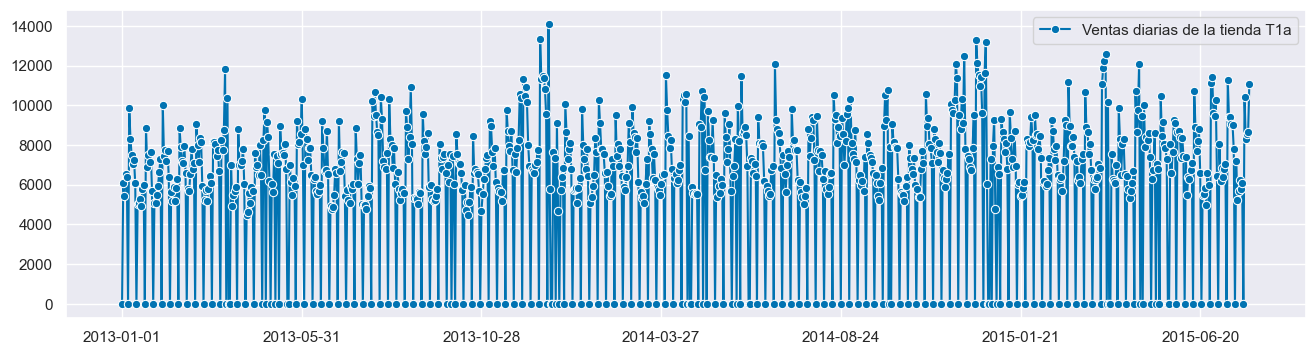

In [124]:
# Plot sales of the T1a store

plot_series(tienda_1_sk, labels=["Ventas diarias de la tienda T1a"])

La serie parece tener una tendencia lineal, llamando la atención el patrón que se repite cada cierto tiempo con el valor 0. Esto se debe a que las tiendas permanecen cerradas durante los domingos y días festivos.

##### Gráfico de la tienda `T1b`

In [125]:
# Select the store
tienda_2 = toscos_df[toscos_df['Store'] == 'T1b']

# Select the columns
tienda_2 = tienda_2[['Date', 'Sales']]

# Index date
tienda_2 = tienda_2.set_index('Date')

# Sktime object
tienda_2_sk= tienda_2.astype('float64').to_period('D').sort_index()
tienda_2_sk.tail()

,Sales
Date,
2015-07-27,9168.0
2015-07-28,8761.0
2015-07-29,7126.0
2015-07-30,7241.0
2015-07-31,12602.0


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

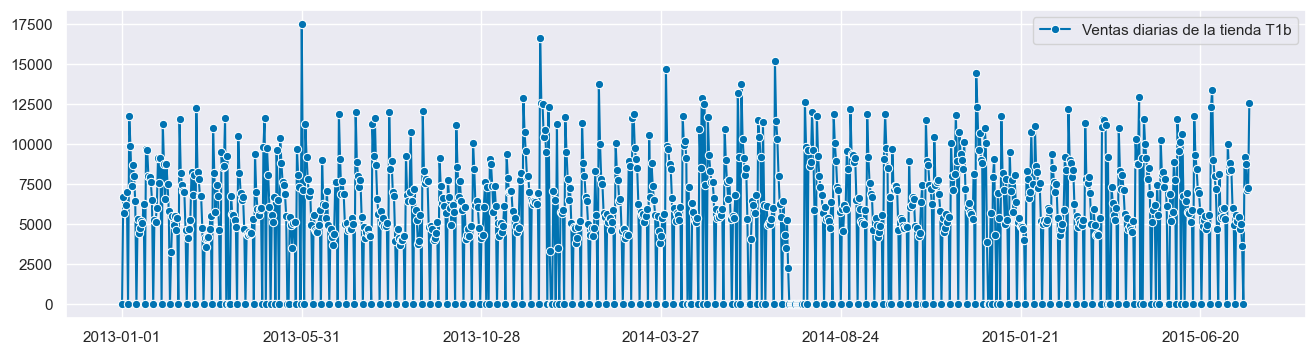

In [126]:
# Plot sales of the T1b store

plot_series(tienda_2_sk, labels=["Ventas diarias de la tienda T1b"])

Se aprecia una fuerte estacionalidad durante el mes de mayo de cada mes. La tendencia se aprecia que es lineal. Por último llama la atención que en el mes de marzo aproximadamente del año 2014 no se obtuvieron ventas durante un buen periodo de tiempo. Esto se debe a que la tienda permanecería cerrada por alguna situación en particular. 

##### Gráfico de la tienda `T1c`

In [127]:
# Select the store
tienda_3 = toscos_df[toscos_df['Store'] == 'T1c']

# Select the columns
tienda_3 = tienda_3[['Date', 'Sales']]

# Index date
tienda_3 = tienda_3.set_index('Date')

# Sktime object
tienda_3_sk= tienda_3.astype('float64').to_period('D').sort_index()
tienda_3_sk.tail()

,Sales
Date,
2015-07-27,5274.0
2015-07-28,5243.0
2015-07-29,4565.0
2015-07-30,4461.0
2015-07-31,5425.0


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

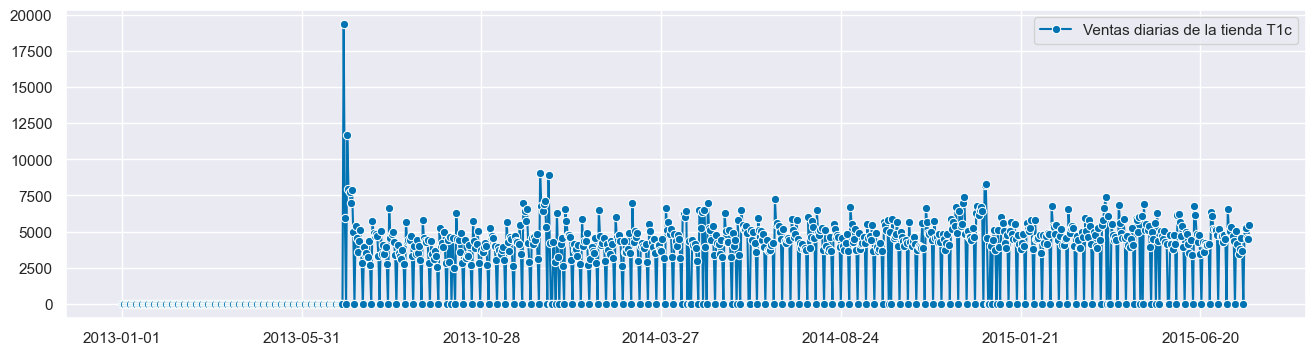

In [128]:
# Plot sales of the T1c store

plot_series(tienda_3_sk, labels=["Ventas diarias de la tienda T1c"])

Esta serie presenta la particularidad de que empiezan a haber datos más tarde que las anteriores y comienza con un valor atípico muy alto. Esto se debe a que esta tienda abriría más tarde que las demás produciéndose un estallido en las ventas al principio del periodo. Por otra parte, las ventas en general son más bajas que las que se encuentran en otras zonas.

Quizás habría que plantearse si esta tienda es o no rentable para supermercados "Toscos" haciendo un balance de los ingresos y gastos.

##### Gráfico de la tienda `T2a`

In [129]:
# Select the store
tienda_4 = toscos_df[toscos_df['Store'] == 'T2a']

# Select the columns
tienda_4 = tienda_4[['Date', 'Sales']]

# Index date
tienda_4 = tienda_4.set_index('Date')

# Sktime object
tienda_4_sk= tienda_4.astype('float64').to_period('D').sort_index()
tienda_4_sk.tail()

,Sales
Date,
2015-07-27,12138.0
2015-07-28,10318.0
2015-07-29,9870.0
2015-07-30,10463.0
2015-07-31,10483.0


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

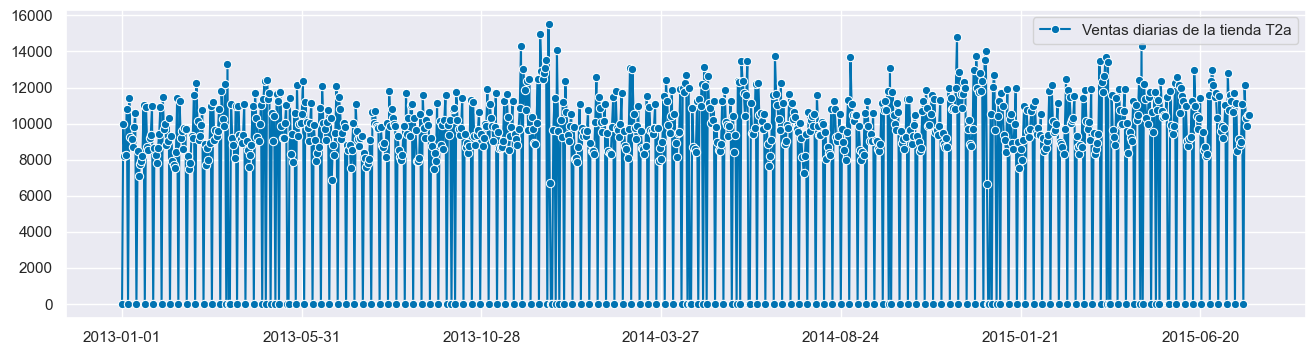

In [130]:
# Plot sales of the T2a store
 
plot_series(tienda_4_sk, labels=["Ventas diarias de la tienda T2a"])

Esta tienda presenta un comportamiento similar a las anteriores. Mismo patrón estacional durante los mismos meses y tendencia lineal. 

##### Gráfico de la tienda `T2b`

In [131]:
# Select the store
tienda_5 = toscos_df[toscos_df['Store'] == 'T2b']

# Select the columns
tienda_5 = tienda_5[['Date', 'Sales']]

# Index date
tienda_5 = tienda_5.set_index('Date')

# Sktime object
tienda_5_sk= tienda_5.astype('float64').to_period('D').sort_index()
tienda_5_sk.tail()

,Sales
Date,
2015-07-27,7031.0
2015-07-28,6093.0
2015-07-29,6896.0
2015-07-30,6561.0
2015-07-31,6456.0


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

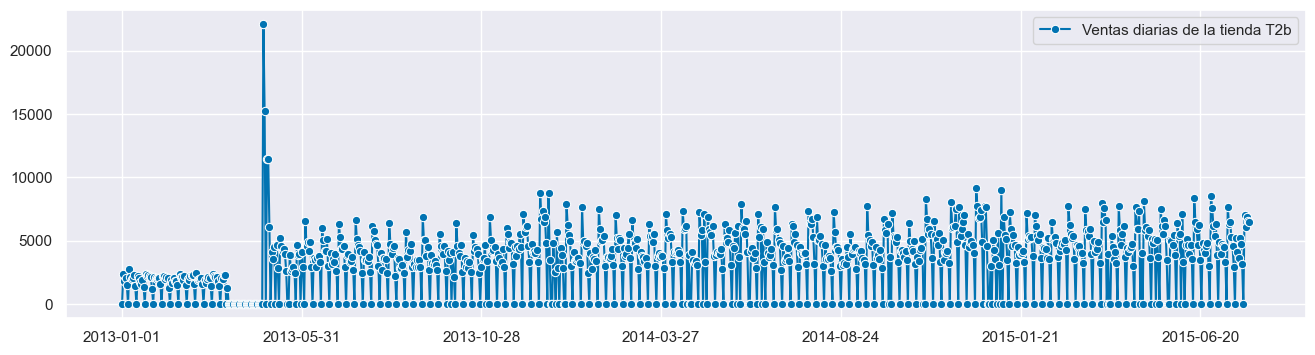

In [132]:
# Plot sales of the T2b store

plot_series(tienda_5_sk, labels=["Ventas diarias de la tienda T2b"])

Destaca el comportamiento de la serie, habiendo un volumen muy bajo de ventas al principio y después un incremento de las ventas, observando un valor atípico muy alto. Además durante el mes de marzo permaneció cerrada sin obtener ventas. Del mismo modo, el volumen de ventas se aprecia bajo con respecto a las anteriores.

##### Gráfico de la tienda `T2c`

In [133]:
# Select the store
tienda_6 = toscos_df[toscos_df['Store'] == 'T2c']

# Select the columns
tienda_6 = tienda_6[['Date', 'Sales']]

# Index date
tienda_6 = tienda_6.set_index('Date')

# Sktime object
tienda_6_sk= tienda_6.astype('float64').to_period('D').sort_index()
tienda_6_sk.tail()

,Sales
Date,
2015-07-27,10318.0
2015-07-28,9178.0
2015-07-29,9141.0
2015-07-30,8253.0
2015-07-31,10845.0


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

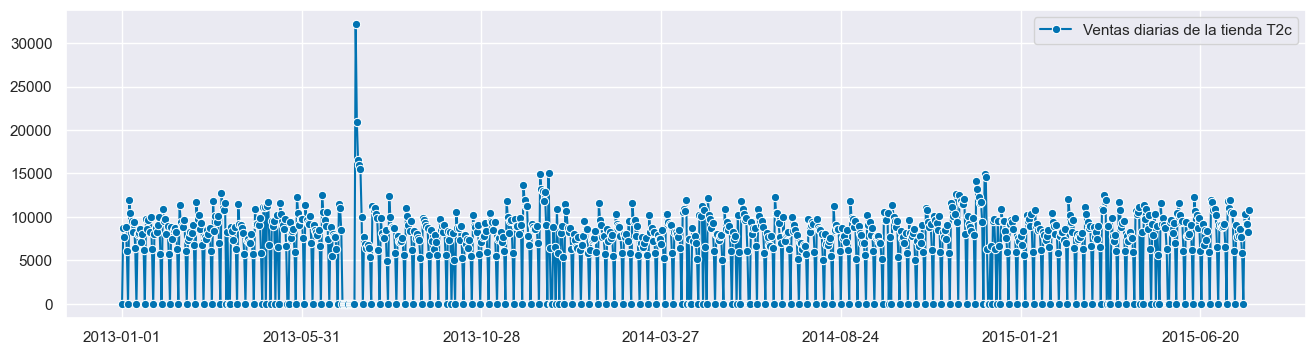

In [134]:
# Plot sales of the T2c store

plot_series(tienda_6_sk, labels=["Ventas diarias de la tienda T2c"])

Presenta un comportamiento similar a las demás tiendas con la particularidad de que presenta un número de ventas más bajo. Llama la atención el valor atípico que puede ser por una campaña de promoción.

##### Gráfico de la tienda `T3a`

In [135]:
# Select the store
tienda_7 = toscos_df[toscos_df['Store'] == 'T3a']

# Select the columns
tienda_7 = tienda_7[['Date', 'Sales']]

# Index date
tienda_7 = tienda_7.set_index('Date')

# Sktime object
tienda_7_sk= tienda_7.astype('float64').to_period('D').sort_index()
tienda_7_sk.tail()

,Sales
Date,
2015-07-27,8800.0
2015-07-28,7472.0
2015-07-29,7017.0
2015-07-30,8132.0
2015-07-31,9194.0


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

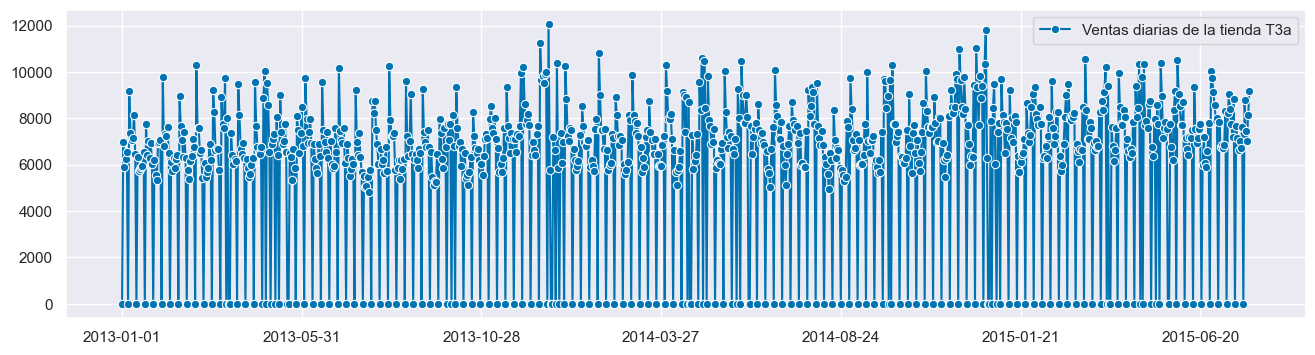

In [136]:
# Plot sales of the T3a store

plot_series(tienda_7_sk, labels=["Ventas diarias de la tienda T3a"])

Presenta un comportamiento similar a la tienda 1 de la zona a. 

##### Gráfico de la tienda `T3b`

In [137]:
# Select the store
tienda_8 = toscos_df[toscos_df['Store'] == 'T3b']

# Select the columns
tienda_8 = tienda_8[['Date', 'Sales']]

# Index date
tienda_8 = tienda_8.set_index('Date')

# Sktime object
tienda_8_sk= tienda_8.astype('float64').to_period('D').sort_index()
tienda_8_sk.tail()

,Sales
Date,
2015-07-27,17513.0
2015-07-28,13684.0
2015-07-29,13273.0
2015-07-30,14082.0
2015-07-31,14927.0


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

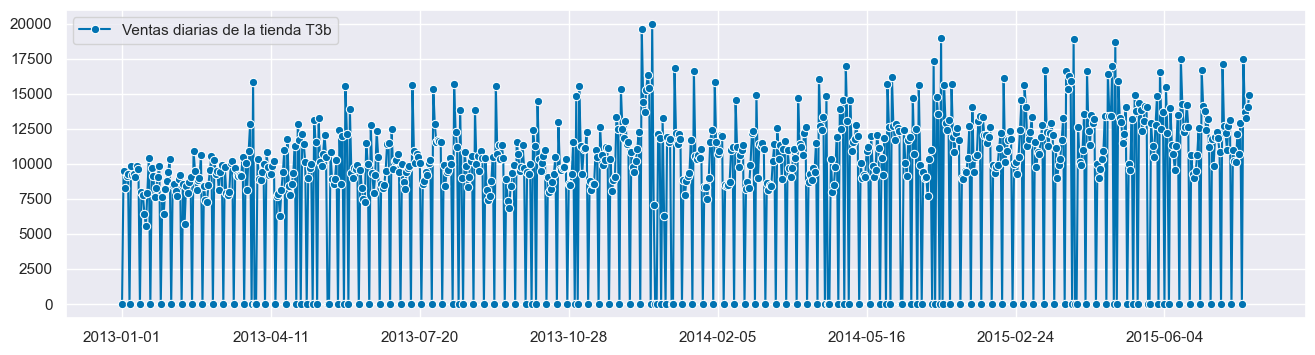

In [138]:
# Plot sales of the T3b store

plot_series(tienda_8_sk, labels=["Ventas diarias de la tienda T3b"])

El gráfico presenta una tendencia lineal y un comportamiento estacional, donde se observan valores atípicos entre el año 2013 y 2014

##### Gráfico de la tienda `T3c`

In [139]:
# Select the store
tienda_9 = toscos_df[toscos_df['Store'] == 'T3c']

# Select the columns
tienda_9 = tienda_9[['Date', 'Sales']]

# Index date
tienda_9 = tienda_9.set_index('Date')

# Sktime object
tienda_9_sk= tienda_9.astype('float64').to_period('D').sort_index()
tienda_9_sk.tail()

,Sales
Date,
2015-07-27,7034.0
2015-07-28,6983.0
2015-07-29,6335.0
2015-07-30,6082.0
2015-07-31,9013.0


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

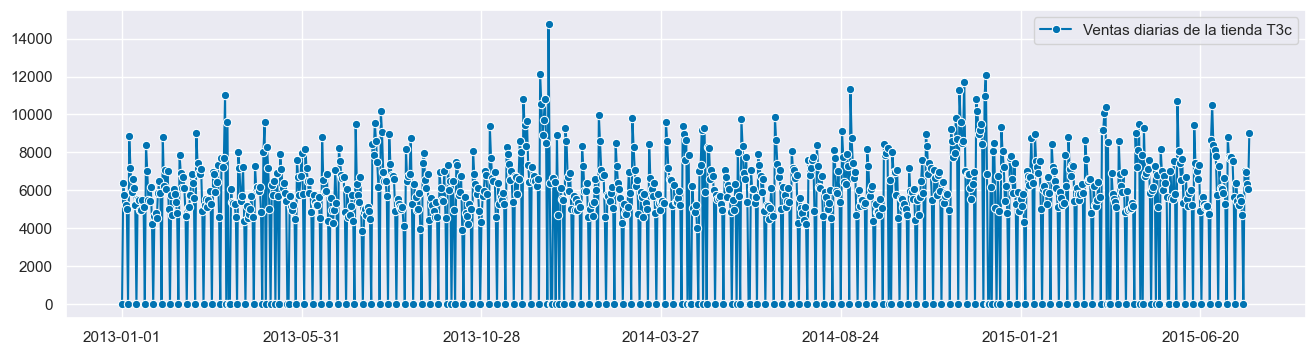

In [140]:
# Plot sales of the T3c store

plot_series(tienda_9_sk, labels=["Ventas diarias de la tienda T3c"])

##### Gráfico de la tienda `T3d`

In [141]:
# Select the store
tienda_10 = toscos_df[toscos_df['Store'] == 'T3d']

# Select the columns
tienda_10 = tienda_10[['Date', 'Sales']]

# Index date
tienda_10 = tienda_10.set_index('Date')

# Sktime object
tienda_10_sk= tienda_10.astype('float64').to_period('D').sort_index()
tienda_10_sk.tail()

,Sales
Date,
2015-07-27,7729.0
2015-07-28,6558.0
2015-07-29,6045.0
2015-07-30,5680.0
2015-07-31,6058.0


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

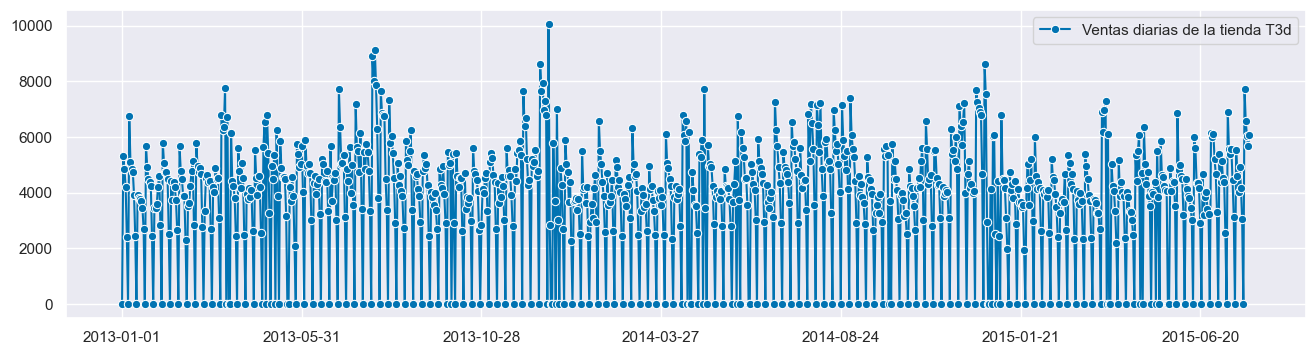

In [142]:
# Plot sales of the T3d store

plot_series(tienda_10_sk, labels=["Ventas diarias de la tienda T3d"])

#### 3.5.3 Análisis gráfico de las 3 zonas

Se separarán por zonas y se graficarán las ventas correspondientes a cada zona.

##### Gráfico de la Zona 1

In [143]:
# Select only the rows which contains T1 in the column 'Store'. With this we take only the stores of the first zone
zona_1 = toscos_df[toscos_df['Store'].str.contains(re.compile("^T1"))]

# Select the columns
zona_1 = zona_1[['Store','Date', 'Sales']]

zona_1.tail()

,Store,Date,Sales
9217,T1b,2013-01-02,6676
9218,T1c,2013-01-02,0
9226,T1a,2013-01-01,0
9227,T1b,2013-01-01,0
9228,T1c,2013-01-01,0


In [144]:
# Verify the uniques values
print("Los valores distintos que nos encontramos en el dataframe zona_1 son: " +str(unique_values(zona_1, 'Store')))

Los valores distintos que nos encontramos en el dataframe zona_1 son: ['T1a', 'T1b', 'T1c']


Podemos observar que únicamente nos hemos quedado con los valores pertenecientes a la zona 1.

In [145]:
# Group by date to sum the Sales of this day in all the stores of the first zone
zona_1 = zona_1.groupby(['Date'])['Sales'].sum().reset_index()

# Index date
zona_1 = zona_1.set_index('Date')

# Sktime object
zona_1_sk= zona_1.astype('float64').to_period('D').sort_index()

zona_1_sk.head()

,Sales
Date,
2013-01-01,0.0
2013-01-02,12748.0
2013-01-03,11143.0
2013-01-04,12727.0
2013-01-05,13406.0


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

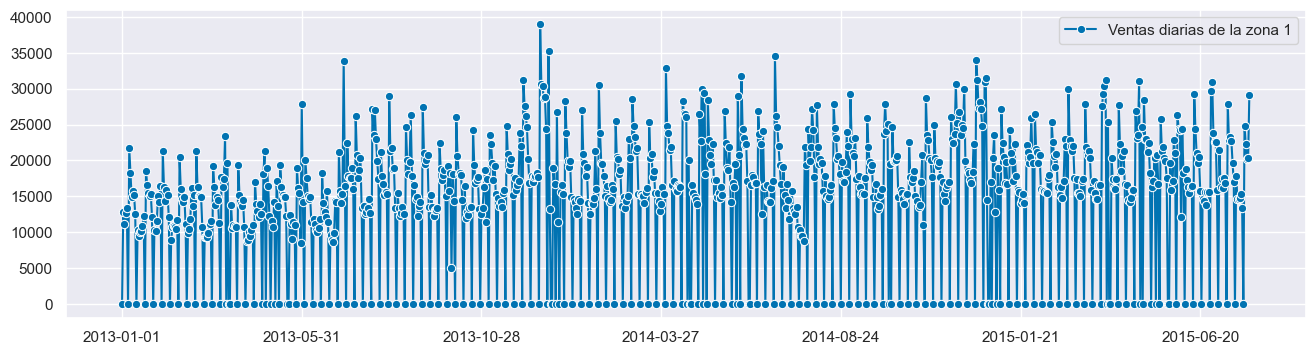

In [146]:
# Plot sales of the first zone

plot_series(zona_1_sk, labels=["Ventas diarias de la zona 1"])

##### Gráfico de la Zona 2

In [147]:
# Select only the rows which contains T2 in the column 'Store'. With this we take only the stores of the first zone
zona_2 = toscos_df[toscos_df['Store'].str.contains(re.compile("^T2"))]

# Select the columns
zona_2 = zona_2[['Store','Date', 'Sales']]

zona_2.tail()

,Store,Date,Sales
9220,T2b,2013-01-02,2326
9221,T2c,2013-01-02,8775
9229,T2a,2013-01-01,0
9230,T2b,2013-01-01,0
9231,T2c,2013-01-01,0


In [148]:
# Verify the uniques values
print("Los valores distintos que nos encontramos en el dataframe zona_2 son: " +str(unique_values(zona_2, 'Store')))

Los valores distintos que nos encontramos en el dataframe zona_2 son: ['T2a', 'T2b', 'T2c']


Podemos observar que únicamente nos hemos quedado con los valores pertenecientes a la zona 2.

In [149]:
# Group by date to sum the Sales of this day in all the stores of the second zone
zona_2 = zona_2.groupby(['Date'])['Sales'].sum().reset_index()

# Index date
zona_2 = zona_2.set_index('Date')

# Sktime object
zona_2_sk= zona_2.astype('float64').to_period('D').sort_index()

zona_2_sk.head()

,Sales
Date,
2013-01-01,0.0
2013-01-02,21078.0
2013-01-03,17686.0
2013-01-04,19077.0
2013-01-05,18328.0


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

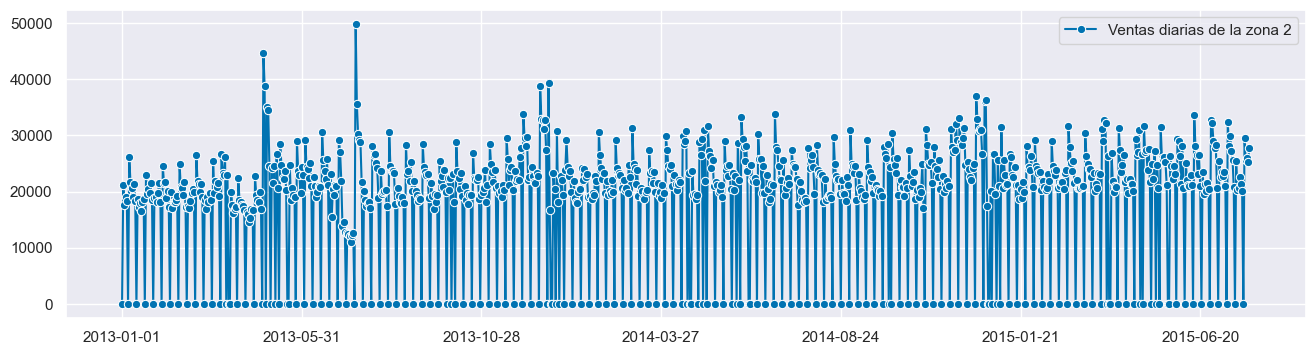

In [150]:
# Plot sales of the second zone

plot_series(zona_2_sk, labels=["Ventas diarias de la zona 2"])

Las estacionalidades se aprecian durante los meses de abril y diciembre de cada año. 

##### Gráfico de la Zona 3

In [151]:
# Select only the rows which contains T3 in the column 'Store'. With this we take only the stores of the first zone
zona_3 = toscos_df[toscos_df['Store'].str.contains(re.compile("^T3"))]

# Select the columns
zona_3 = zona_3[['Store','Date', 'Sales']]

zona_3.head()

,Store,Date,Sales
6,T3a,2015-07-31,9194
7,T3b,2015-07-31,14927
8,T3c,2015-07-31,9013
9,T3d,2015-07-31,6058
16,T3a,2015-07-30,8132


In [152]:
# Verify the uniques values
print("Los valores distintos que nos encontramos en el dataframe zona_3 son: " +str(unique_values(zona_3, 'Store')))

Los valores distintos que nos encontramos en el dataframe zona_3 son: ['T3a', 'T3b', 'T3c', 'T3d']


Podemos observar que únicamente nos hemos quedado con los valores pertenecientes a la zona 3.

In [153]:
# Group by date to sum the Sales of this day in all the stores of the third zone
zona_3 = zona_3.groupby(['Date'])['Sales'].sum().reset_index()

# Index date
zona_3 = zona_3.set_index('Date')

# Sktime object
zona_3_sk= zona_3.astype('float64').to_period('D').sort_index()

zona_3_sk.head()

,Sales
Date,
2013-01-01,0.0
2013-01-02,28100.0
2013-01-03,24759.0
2013-01-04,24774.0
2013-01-05,23204.0


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

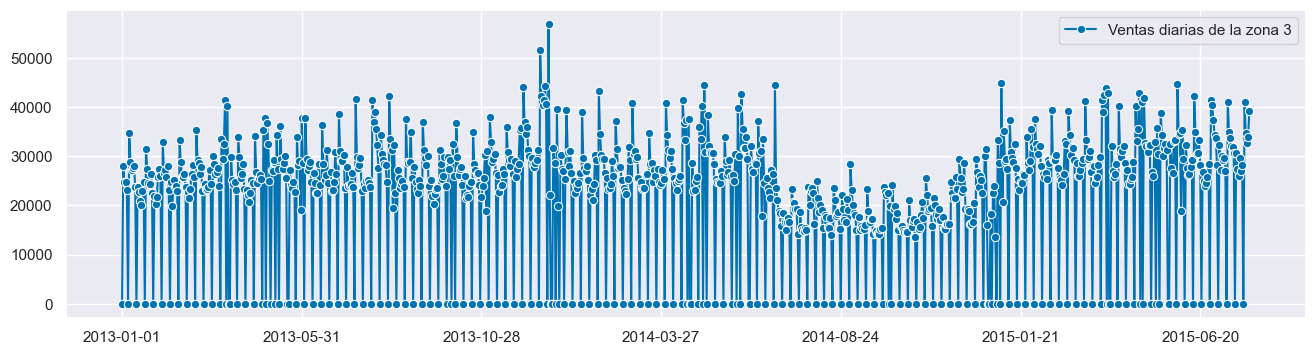

In [154]:
# Plot sales of the third zone

plot_series(zona_3_sk, labels=["Ventas diarias de la zona 3"])

La particularidad de este gráfico es que desde el mes de junio-julio del año 2014 hasta el año 2015 se produce un descenso notable en las ventas. El resto de la serie se comporta de una manera normal. 

#### 3.5.4 Análisis gráfico de las ventas totales diarias

Con la finalidad de conocer las ventas totales diarias se realizará un gráfico para ver su evolución en el tiempo.

Para ello hay que sumar las ventas diarias de cada una de las tiendas y agruparlas para posteriormente realizar el gráfico.

In [155]:
# Select the columns Store, Date and Sales

toscos_df = toscos_df[['Store','Date', 'Sales']]
toscos_df.tail()

,Store,Date,Sales
9231,T2c,2013-01-01,0
9232,T3a,2013-01-01,0
9233,T3b,2013-01-01,0
9234,T3c,2013-01-01,0
9235,T3d,2013-01-01,0


In [156]:
# Group by date to add all Sales of the day. 

total_sales_daily = toscos_df.groupby(['Date'])['Sales'].sum().reset_index()

# Index date
total_sales_daily = total_sales_daily.set_index('Date')

total_sales_daily.head()

,Sales
Date,
2013-01-01,0
2013-01-02,61926
2013-01-03,53588
2013-01-04,56578
2013-01-05,54938


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

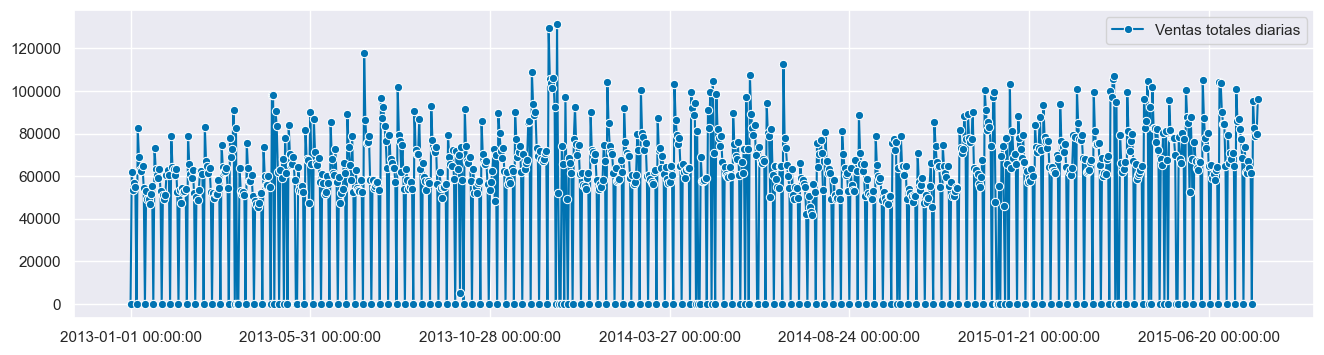

In [157]:
# Plot total Sales of the day

plot_series(total_sales_daily, labels=["Ventas totales diarias"])

Test de raíces unitarias *Dickey Fuller* para comprobar la estacionariedad de la serie.

In [158]:
adf1 = adfuller(total_sales_daily['Sales'], maxlag = 1)

print('El T-test es:', adf1[0])
print('El p-value es:', adf1[1])

El T-test es: -24.584661062664388
El p-value es: 0.0


Como el p-valor es menor que 0.05, se rechaza la hipótesis nula y por tanto la serie es estacionaria, pues es constante en media y en varianza

Descomposición de la serie temporal de las ventas diarias para analizar tendencia y estacionalidad.

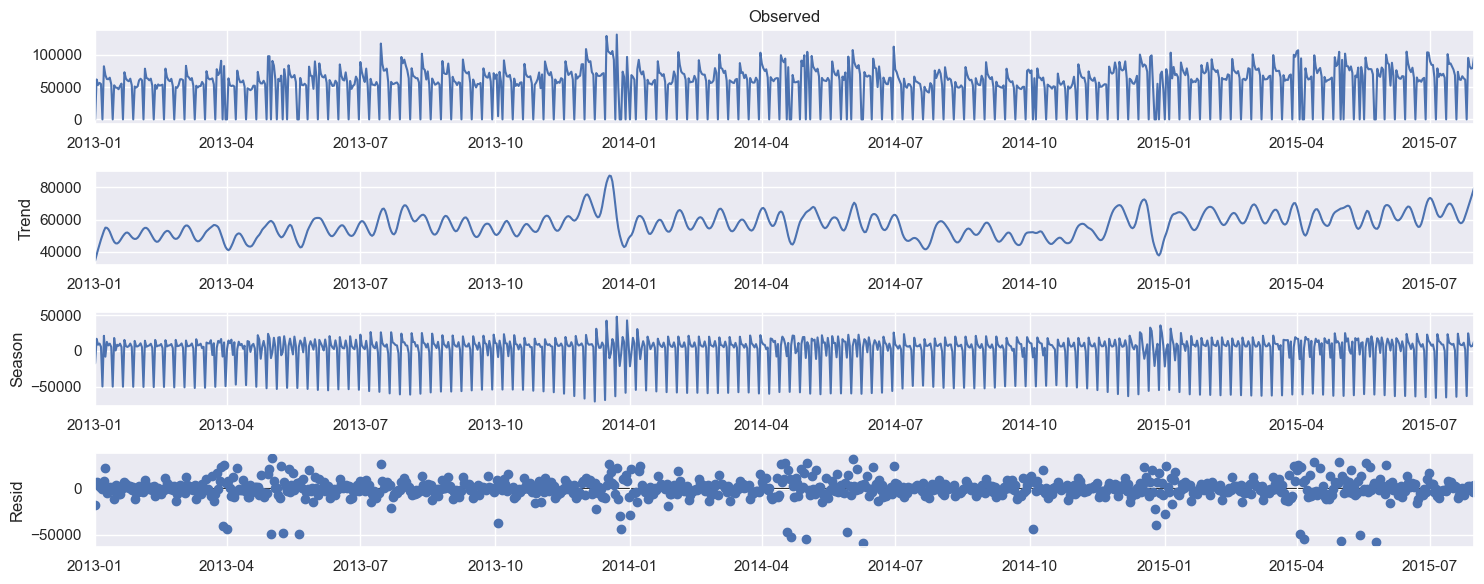

In [159]:
rst = STL(total_sales_daily).fit()
rst.plot()
plt.show()

La serie presenta una muy leve tendencia creciente. Además, se observa una fuerte estacionalidad semanal, ya que los domingos y días festivos las tiendas permanecen cerradas por lo que no se obtienen ventas. 

#### 3.5.5 Análisis gráfico de las ventas totales semanales

Para poder graficar las ventas totales semanales hay que convertir los datos diarios a semanal. Para ello primero se seleccionan las columnas de fecha y ventas, posteriormente se convierten a semanales. Como tenemos 10 tiendas tendríamos 10 semanas y para simplificar todo ello se han agrupado todas las ventas, con la finalidad de obtener las ventas totales semanales de supermercados Toscos.

In [160]:
# Select the columns Store, Date and Sales

total_sales_week = toscos_df[['Date', 'Sales']]

# Index date
total_sales_week = total_sales_week.set_index('Date')

# Sktime object to week
total_sales_week = total_sales_week.astype('float64').to_period('W').sort_index()

# Group by date to add all Sales of the day. 
total_sales_week = total_sales_week.groupby(['Date'])['Sales'].sum().reset_index()

# Convert the Date column to the format '%Y-%m-%d'.
total_sales_week['Date'] = total_sales_week['Date'].dt.strftime('%Y-%m-%d')

# Convert the Date column to datetime
total_sales_week['Date'] = pd.to_datetime(total_sales_week['Date'],format="%Y/%m/%d")

# Index date
total_sales_week = total_sales_week.set_index('Date')

total_sales_week.tail()

,Sales
Date,
2015-07-05,531819.0
2015-07-12,419561.0
2015-07-19,501709.0
2015-07-26,389502.0
2015-08-02,432467.0


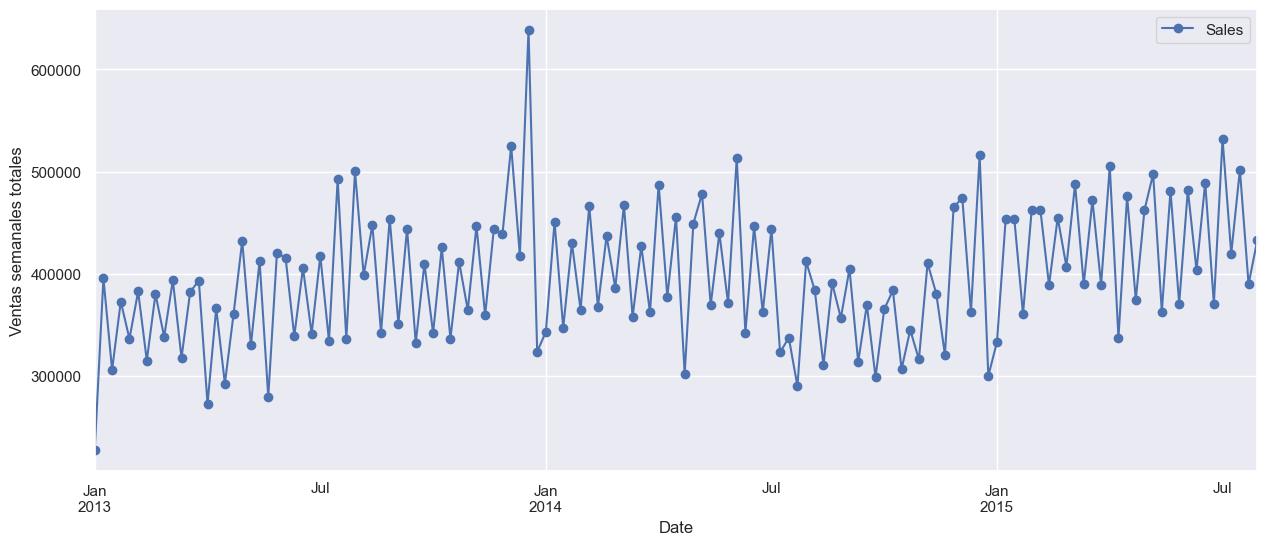

In [161]:
sns.set(rc={'figure.figsize':(15, 6)})
ax = total_sales_week.plot(marker='o', linestyle='-')
ax.set_ylabel('Ventas semanales totales');

El gráfico presenta una tendencia creciente y estacionalidad a simple vista no se aprecia. La serie deja ver un valor significativamente alto con respecto a los demás en el mes de diciembre del año 2013. 

Test de raíces unitarias *Dickey Fuller* para comprobar la estacionariedad de la serie.

In [162]:
adf = adfuller(total_sales_week['Sales'], maxlag = 1)

print('El T-test es:', adf[0])
print('El p-value es:', adf[1])

El T-test es: -5.356775675919936
El p-value es: 4.172147212535939e-06


Como el p-valor es menor que 0.05, se rechaza la hipótesis nula y por tanto la serie es estacionaria, pues es constante en media y varianza.

Para realizar un análisis de su tendencia y estacionalidad se realiza la descomposición de la serie temporal.

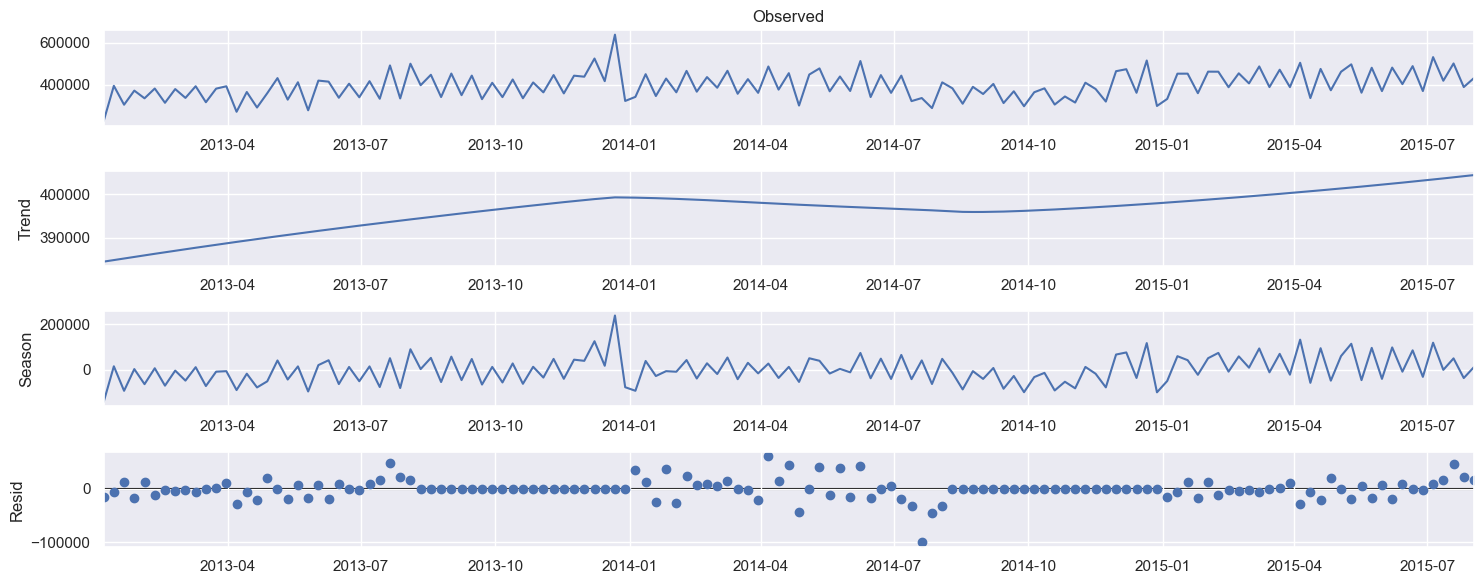

In [163]:
rst2 = STL(total_sales_week).fit()
rst2.plot()
plt.show()

La serie presenta una tendencia creciente. Con respecto a la estacionalidad se aprecia que no hay. 